Author: Carlos Roberto de Melo

Date: 05/27/2020
    
Obj: Construct the velocity dispersion map/Construir o mapa de dispersão de velocidade

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot

from scipy.interpolate import interp2d
import scipy.interpolate
from scipy import ndimage

from plotbin.sauron_colormap import register_sauron_colormap

from mpdaf.obj import Image, WCS

In [9]:
entrada = np.loadtxt('Test2.txt') #Reads the table with the adjustment data/Lê a tabela com os dados do ajuste
y = [] #y position in px value/Posição y em valor de px
x = [] #x position in px value/Posição x em valor de px
disp = [] #velocity dispersion/dispersão de velocidade
vel = [] #velocity
chi = [] #1-sigma error on velocity
erro = [] #1-sigma error on velocity dispersion


grid = Image('/home/carlos/Documents/GitHub/Master-Degree/ESO325/Dynamical Modelling/pPXF/Data/New Grid.fits') #Reads the empty grid with 0.6''/Abrindo o grid vazio com 0.6''

for i in range(400):
    y.append(entrada[i][0])
    x.append(entrada[i][1]) 
    disp.append(entrada[i][3])
    vel.append(entrada[i][2])
    chi.append(entrada[i][4])
    erro.append(entrada[i][5])
    

#Vamos calcular a velocidade V_rms e o erro propagado para ela.
    #Note que subtraimos a velocidade vel[189], pois essa é a velocidade do px central.
    

vel = vel - vel[189]
vrms = np.sqrt(np.array(vel)**2 + np.array(disp)**2) #Vrms velocity
erms = np.array(erro)#error in vrms

In [10]:
#We now associate the corresponding speed dispersion value to each px 
    #in the grid. And in the variance of the grid we associate the error.
#Agora associamos a cada px do grid o valor correspondente da dispersão
    #de velocidades. E na variância do grid associamos o erro.  
for i in range(400):
    grid[np.int(entrada[i][0]),np.int(entrada[i][1])] = vrms[i]
    grid.var[np.int(entrada[i][0]),np.int(entrada[i][1])] = erms[i]

#Transpose the array to make the map below/Transpõe o array, pedido para fazer o mapa abaixo
x_new = np.transpose(x) 
y_new = np.transpose(y)
vrms = np.transpose(vrms)

grid.write('/home/carlos/Documents/GitHub/Master-Degree/ESO325/Dynamical Modelling/pPXF/Data/Test2.fits')#Save the map in .fits/Saalva o mapa em .fits

Function that performs the plot of the dispersion map. The original code is the plotbin, developed by Cappellari./
Função que realiza o plot do mapa de dispersão. Código original é o plotbin, desenvolvido por Cappellari.

In [11]:
def plot_velfield(x, y, vel, vmin=None, vmax=None, ncolors=64,
                  nodots=False, colorbar=False, linescolor='k', label=None, 
                  flux=None, nticks=7, markersize=3, cmap=plt.cm.hot, **kwargs):

    x, y, vel, flux = map(np.ravel, [x, y, vel, flux])

    assert x.size == y.size == vel.size, 'The vectors (x, y, vel) must have the same size'

    if cmap in ['sauron', 'sauron_r']:
        register_sauron_colormap()

    if vmax is None and vmin is None:
        vmin, vmax = np.min(vel), np.max(vel)
        extend = 'neither'
    elif vmax is None:
        vmax = np.max(vel)
        extend = 'min'
    elif vmin is None:
        vmin = np.min(vel)
        extend = 'max'
    else:
        extend = 'both'

    levels = np.linspace(vmin, vmax, ncolors)

    ax = plt.gca()

    cnt = ax.tricontourf(x, y, vel, levels=levels, cmap=cmap, extend=extend, **kwargs)

    for c in cnt.collections:    # Remove white gaps in contour levels of PDF
        c.set_edgecolor("face")  # http://stackoverflow.com/a/32911283/

    ax.axis('image')  # Equal axes and no rescaling
    ax.minorticks_on()
    ax.tick_params(length=10, which='major')
    ax.tick_params(length=5, which='minor')

    if flux[0] is not None:
        ax.tricontour(x, y, -2.5*np.log10(flux/np.max(flux).ravel()),
                      levels=np.arange(20), colors=linescolor)  # 1 mag contours

    if not nodots:
        ax.plot(x, y, '.k', markersize=markersize, **kwargs)

    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
        cbar = plt.colorbar(cnt, cax=cax, ticks=ticks)
        if label is not None:
            cbar.set_label(label)
        plt.sca(ax)  # Activate main plot before returning

    return cnt

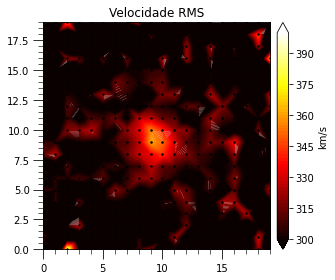

In [12]:
#Plot the velocity dispersion map/Plota o mapa de dispersão de velocidade
plt.clf()
plt.title('Velocidade RMS')
plot_velfield(x_new,y_new, vrms,vmin=300, vmax=400, colorbar=True, label='km/s')
plt.tight_layout()
#plt.savefig('/home/carlos/Desktop/ESO325 MUSE-ColletBinning (01-07-20)/Figs/Velocity DRMS-plot with vorbin Second Run.png', fmt='png', dpi=1200)
plt.show()

Plot the same  map with other interpolation method/Plota o mesmo mapa, mas com outros métodos de interpolação

In [49]:
xi, yi = np.linspace(x_new.min(), x_new.max(), 64), np.linspace(y_new.min(), y_new.max(), 100)
xi, yi = np.meshgrid(xi, yi)
rbf = scipy.interpolate.Rbf(x_new, y_new, vrms, function='cubic')
zi = rbf(xi, yi)

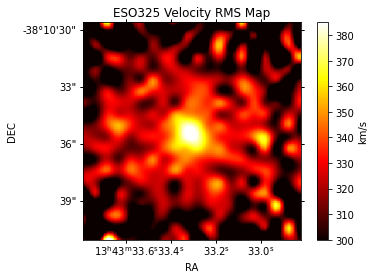

In [51]:
fig = plt.figure()
fig.add_subplot(111, projection=grid.wcs.wcs)
plt.imshow(zi, vmin=300, vmax=385, origin='lower',
           extent=[x_new.min(), x_new.max(), y_new.min(), y_new.max()], cmap=plt.cm.hot)
#plt.scatter(x_new, y_new, c=dis_new, cmap=plt.cm.hot)
plt.colorbar(label='km/s')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('ESO325 Velocity RMS Map')
plt.savefig('/home/carlos/Desktop/ESO325 MUSE-ColletBinning (01-07-20)/Figs/Velocity RMS map second run.png', fmt='png', dpi=1200)
plt.show()